## Initialize the Datasets

In [2]:
from fov.graph.dataset import CarlaFieldOfViewDataset
import torch
from torch.utils.data import random_split
from torch_geometric.transforms import ToDevice
from torch_geometric.loader import DataLoader

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")

data_dir_input = "/data/shared/CARLA/multi-agent-v1"
data_dir_output = "/data/shared/fov"

full_dataset = CarlaFieldOfViewDataset(
    carla_root_directory=data_dir_input,
    graph_root_directory=data_dir_output,
    include_infrastructure_agents=False,
    n_frames_max=1000,
    force_reload=False,
    transform=ToDevice(device=device),
)

# assume we did the same split in the training process...yikes
train_dataset, val_dataset, test_dataset = random_split(full_dataset, (0.5, 0.3, 0.2))
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10)

Using device cuda:1


## Initialize the Models

In [3]:
import os

weight_dir = "graph_training"
last_subdir = sorted(next(os.walk(weight_dir))[1])[-1]

In [6]:
from fov.graph.models import GATModel, AVstackGraphWrapper
from avstack.modules.perception.fov_estimator import (
    FastRayTraceBevLidarFovEstimator,
    SlowRayTraceBevLidarFovEstimator,
)


# load the neural network weights
epoch = 3
weights_path = os.path.join(weight_dir, last_subdir, f"epoch_{epoch}.pth")
gat_model = GATModel(
    in_channels=-1,
    hidden_channels=256,
    num_layers=5,
    out_channels=1,
    v2=True,
).to(device)
gat_model.load_state_dict(torch.load(weights_path))
gat_model.eval()

# set up the models
models = [
    gat_model,
    # AVstackGraphWrapper(FastRayTraceBevLidarFovEstimator()),
    # AVstackGraphWrapper(SlowRayTraceBevLidarFovEstimator()),
]

## Visualization Tools

In [8]:
def visualize_truth(data, ax, show_truth: bool = True):
    # -- show all original points
    ax.scatter(
        data.x[:, 0],
        data.x[:, 1],
        s=10,
        color="blue",
        label="All points",
    )

    # -- show the ground truth label
    if show_truth:
        ax.scatter(
            data.x[data.y, 0],
            data.x[data.y, 1],
            s=40,
            color="green",
            label="Truth boundary points",
            facecolors="none",
            linewidths=1,
        )


def visualize_prediction(data, prediction, ax):
    # -- show the model prediction
    ax.scatter(
        data.x[prediction, 0],
        data.x[prediction, 1],
        s=40,
        color="red",
        label="Predicted boundary points",
        facecolors="none",
        linewidths=1,
    )

## Run the Analysis

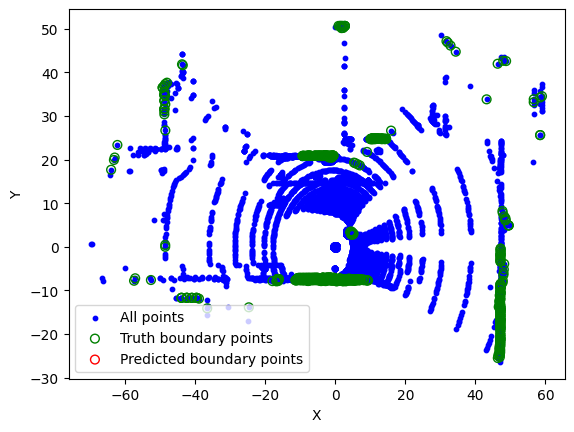

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)

graph = test_dataset[1]
pred = gat_model(graph).cpu() > 0.7
gcpu = graph.cpu()

visualize_truth(gcpu, ax)
visualize_prediction(gcpu, pred, ax)

plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()

In [28]:
metrics = test_all(models, threshold=0.7)

100%|██████████| 50/50 [00:48<00:00,  1.04it/s]


In [29]:
print(metrics)

[{'n_total': [116761, 117401, 117075, 117029, 117015, 116996, 117489, 116960, 116795, 116284, 116971, 117144, 116226, 116863, 116880, 116943, 117322, 117026, 117213, 117110, 116667, 117092, 116787, 116902, 117515, 117375, 117208, 116798, 116922, 117082, 117072, 116993, 116990, 116883, 116970, 117410, 116861, 116565, 117008, 116959, 116924, 117231, 116927, 117037, 117364, 116536, 117313, 117418, 116632, 116897], 'n_positive': [tensor(18232, device='cuda:1'), tensor(21237, device='cuda:1'), tensor(20555, device='cuda:1'), tensor(20486, device='cuda:1'), tensor(17434, device='cuda:1'), tensor(17435, device='cuda:1'), tensor(20714, device='cuda:1'), tensor(15343, device='cuda:1'), tensor(22181, device='cuda:1'), tensor(15925, device='cuda:1'), tensor(17133, device='cuda:1'), tensor(16619, device='cuda:1'), tensor(14196, device='cuda:1'), tensor(17221, device='cuda:1'), tensor(18144, device='cuda:1'), tensor(18624, device='cuda:1'), tensor(19251, device='cuda:1'), tensor(18923, device='cuda